In [38]:
import os
import cv2
import pandas as pd
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Google Colab amount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#local에 풀기
#data_location 위치에 다운로드받은 zip파일이 위치한 디렉토리 입력

!mkdir /content/datasets # 폴더 없을 경우 생성
!unzip "/content/drive/MyDrive/unid2023/datasets/train.zip" -d "/content/datasets/train"
!unzip "/content/drive/MyDrive/unid2023/datasets/test.zip" -d "/content/datasets/test"
%cd /content/

mkdir: cannot create directory ‘/content/datasets’: File exists
Archive:  /content/drive/MyDrive/unid2023/datasets/train.zip
replace /content/datasets/train/images/train_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/drive/MyDrive/unid2023/datasets/test.zip
replace /content/datasets/test/images/test_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
/content


# Custom Dataset


In [43]:
class SegDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, resize=(512, 512), mode='train',augmentation=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.resize = resize
        self.mode = mode
        self.augmentation = augmentation

        if augmentation:
            self.transform = A.Compose([
                *augmentation,  # Unpack the augmentation list
                A.Resize(*resize),
                #A.Normalize(),
                ToTensorV2()
            ])
        else:
            self.transform = A.Compose([
                A.VerticalFlip(p=0.25),
                A.Rotate(limit=45, p=0.25),
                A.Resize(512,512),
                A.Normalize(),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.mode in ['train', 'val']:
            mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
            augmented = self.transform(image=image, mask=mask)
            return augmented['image'], augmented['mask']

        else:
            return self.transform(image=image)['image']

In [5]:

augmentations = [

    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
    A.CropNonEmptyMaskIfExists(height=256, width=256, p=0.3),
    A.ToGray(p=0.3),

]

In [6]:
def apply_mask_color(mask):
    # 클래스별 색상 정의 (예시)
    colors = {
        0: (0, 0, 0),      # 배경
        1: (255, 0, 0),    # 클래스 1
        2: (0, 255, 0),    # 클래스 2
        3: (0, 0, 255),    # 클래스 3
        4: (125, 125, 0),    # 클래스 4
        5: (0, 125, 125),    # 클래스 5
        6: (125, 125, 0),    # 클래스 6
        7: (125, 125, 125),    # 클래스 7
        8: (225, 80, 80),    # 클래스 8
        9: (80, 255, 80),    # 클래스 9


    }

    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for key, value in colors.items():
        colored_mask[mask == key] = value

    return colored_mask


In [7]:
!pip install matplotlib

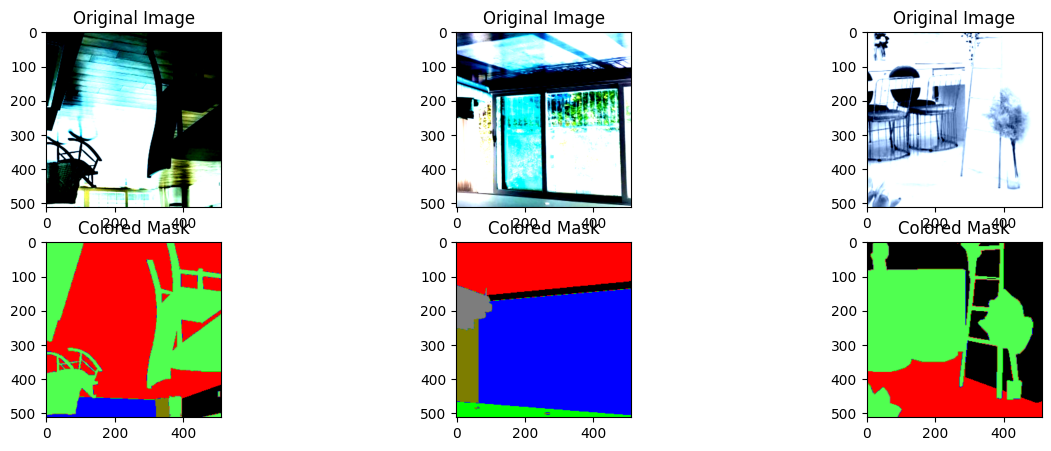

In [8]:
import matplotlib.pyplot as plt

# 데이터셋 인스턴스 생성
data_directory = '/content/datasets'
train_image_paths = sorted(glob(os.path.join(data_directory, 'train', 'images', '*.jpg')))
train_mask_paths = sorted(glob(os.path.join(data_directory, 'train', 'masks', '*.png')))
test_image_paths = sorted(glob(os.path.join(data_directory, 'test', 'images', '*.jpg')))

train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(train_image_paths, train_mask_paths, test_size=0.2, random_state=2021)

dataset = SegDataset(train_image_paths, train_mask_paths, resize=(512, 512), mode='train', augmentation=augmentations)

# 데이터 추출 및 시각화
plt.figure(figsize=(15, 5))

for i in range(3):  # 3개의 샘플을 시각화
    image, mask = dataset[i]  # 데이터셋에서 샘플을 가져옴

    colored_mask = apply_mask_color(mask)
    image = image.numpy().transpose(1, 2, 0)
    plt.subplot(2, 3, i+1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(2, 3, i+4)
    plt.imshow(colored_mask)
    plt.title('Colored Mask')

plt.show()


In [9]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        self.dconv_down1 = double_conv(n_channels, 32)
        self.dconv_down2 = double_conv(32, 64)
        self.dconv_down3 = double_conv(64, 128)
        self.dconv_down4 = double_conv(128, 256)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(128 + 256, 128)
        self.dconv_up2 = double_conv(64 + 128, 64)
        self.dconv_up1 = double_conv(64 + 32, 32)

        self.conv_last = nn.Conv2d(32, n_classes, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [39]:
from sklearn.model_selection import KFold
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from glob import glob


# KFold 인스턴스 생성
kf = KFold(n_splits=5, shuffle=True, random_state=2021)

In [11]:
import torch

def iou(pred, target, n_classes = 10):
    ious = []
    pred = torch.argmax(pred, dim=1).view(-1)
    target = target.view(-1)

    # Ignore IoU for background class
    for cls in range(1, n_classes):  # this assumes the background is class 0
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().item()  # Convert tensor to scalar
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection

        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append(float(intersection) / max(union, 1))
    return np.array(ious)

In [12]:
from tqdm import tqdm
import torch.optim as optim
import numpy as np
import os

class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_loss = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [44]:
from torchvision import models
import torch.optim as optim
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm
import numpy as np

# 기타 필요한 모듈 및 함수 정의가 여기에 포함되어야 함 (예: SegDataset, EarlyStopping 등)

batch_size = 16
lr = 0.001
num_epochs = 30
num_classes = 10  # 클래스 수 정의

# 데이터 로드 및 분할
data_directory = '/content/datasets'
train_image_paths = sorted(glob(os.path.join(data_directory, 'train', 'images', '*.jpg')))
train_mask_paths = sorted(glob(os.path.join(data_directory, 'train', 'masks', '*.png')))
test_image_paths = sorted(glob(os.path.join(data_directory, 'test', 'images', '*.jpg')))

train_dataset = SegDataset(train_image_paths, train_mask_paths, resize=(512, 512), mode='train')
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(train_image_paths, train_mask_paths, test_size=0.2, random_state=2021)


val_dataset = SegDataset(val_image_paths, val_mask_paths, mode='val')
test_dataset = SegDataset(test_image_paths, mode='test')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=1, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=1, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=1)

# DeepLabV3 모델 초기화 및 마지막 레이어 변경
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1), stride=(1,1))
model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1), stride=(1,1))
model = model.to(device)

# Optimizer 및 Loss function 정의
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
early_stopping = EarlyStopping(patience=5, verbose=True)

# 학습 및 검증 루프
best_loss = np.inf
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    total_ious = []
    for images, masks in tqdm(train_loader):
        images = images.float().to(device)
        masks = masks.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        ious = iou(outputs, masks)
        total_ious.append(ious)
        optimizer.step()

        epoch_loss += loss.item()

    current_lr = optimizer.param_groups[0]['lr']
    epoch_loss = epoch_loss / len(train_loader)
    mIoU = np.nanmean(total_ious)


    # 검증 데이터셋에 대한 손실 계산
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_images, val_masks in val_loader:
            val_images = val_images.float().to(device)
            val_masks = val_masks.long().to(device)
            val_outputs = model(val_images)['out']
            val_loss += criterion(val_outputs, val_masks).item()
        val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Val_Loss: {val_loss}, mIoU: {mIoU}, LR: {current_lr}')
    # 스케줄러 업데이트
    scheduler.step(val_loss)

     #Early Stopping 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Best Model 저장
    if val_loss < best_loss:
        best_loss = val_loss
        # 에포크 번호를 포함하여 파일 이름 생성
        filename = f'best_deeplabv3_{epoch}.pth'

        # 모델의 상태를 파일로 저장
        torch.save(model.state_dict(), filename)


        print('save_best_model')

        filename = f'best_deeplabv3_{epoch}.pth'

        # 모델의 상태를 파일로 저장
        torch.save(model.state_dict(), filename)


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 1, Loss: 0.7950026742343245, Val_Loss: 0.9939890332605646, mIoU: 0.4711883976155304, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 2, Loss: 0.5532841770813383, Val_Loss: 0.5503257372598539, mIoU: 0.5959084546274952, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 3, Loss: 0.48050383562329174, Val_Loss: 0.5048990222229355, mIoU: 0.639321027390267, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:07<00:00,  1.75it/s]


Epoch 4, Loss: 0.43799742206759834, Val_Loss: 0.4184743655824113, mIoU: 0.6644114206545361, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:07<00:00,  1.75it/s]


Epoch 5, Loss: 0.4127800668793163, Val_Loss: 0.3960847292823353, mIoU: 0.6831882313379132, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:07<00:00,  1.75it/s]


Epoch 6, Loss: 0.3853927955545228, Val_Loss: 0.3814775995139418, mIoU: 0.6985598386483826, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:07<00:00,  1.75it/s]


Epoch 7, Loss: 0.3611195762952169, Val_Loss: 0.3581624435282302, mIoU: 0.7133545035069778, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:07<00:00,  1.75it/s]


Epoch 8, Loss: 0.34908215180895796, Val_Loss: 0.40619991942383776, mIoU: 0.7204238042501684, LR: 0.001


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 9, Loss: 0.3365274331692992, Val_Loss: 0.4393383925673605, mIoU: 0.7303840062417164, LR: 0.001


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 10, Loss: 0.3215212503726455, Val_Loss: 0.4989679305032752, mIoU: 0.7384875684814082, LR: 0.001


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 11, Loss: 0.30669766664505005, Val_Loss: 0.31433191124735205, mIoU: 0.7498660864496025, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 12, Loss: 0.3001661148564569, Val_Loss: 0.595268984635671, mIoU: 0.7554675003654076, LR: 0.001


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 13, Loss: 0.29346288946168175, Val_Loss: 0.2817377245974267, mIoU: 0.7588780587654264, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:07<00:00,  1.75it/s]


Epoch 14, Loss: 0.28257883660409644, Val_Loss: 0.28306120240140237, mIoU: 0.7651432304871214, LR: 0.001


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 15, Loss: 0.2748051373780459, Val_Loss: 0.2609170534829984, mIoU: 0.7707257275103278, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:07<00:00,  1.76it/s]


Epoch 16, Loss: 0.264623700613263, Val_Loss: 0.2721902364971994, mIoU: 0.7766173290815398, LR: 0.001


100%|██████████| 435/435 [04:07<00:00,  1.75it/s]


Epoch 17, Loss: 0.2613034038023017, Val_Loss: 0.2762325673267759, mIoU: 0.7798630671959199, LR: 0.001


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 18, Loss: 0.24873253778479565, Val_Loss: 0.27138532150065764, mIoU: 0.7910978406020853, LR: 0.001


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 19, Loss: 0.2460887601320771, Val_Loss: 0.2364427736778369, mIoU: 0.7916540726767872, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:07<00:00,  1.76it/s]


Epoch 20, Loss: 0.23360135038008636, Val_Loss: 0.24067718184542383, mIoU: 0.8002342311669258, LR: 0.001


100%|██████████| 435/435 [04:07<00:00,  1.75it/s]


Epoch 21, Loss: 0.229426301895887, Val_Loss: 0.24277967625650868, mIoU: 0.8029707654264521, LR: 0.001


100%|██████████| 435/435 [04:07<00:00,  1.75it/s]


Epoch 22, Loss: 0.22365961359150108, Val_Loss: 0.22893925302330104, mIoU: 0.8072588863366473, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:07<00:00,  1.76it/s]


Epoch 23, Loss: 0.2276679915943365, Val_Loss: 0.2710576992610405, mIoU: 0.8046427453374349, LR: 0.001


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 24, Loss: 0.21941445620580652, Val_Loss: 0.2063571255782555, mIoU: 0.8104688140066916, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:07<00:00,  1.76it/s]


Epoch 25, Loss: 0.2158836655918209, Val_Loss: 0.20319605695790258, mIoU: 0.8131628816799236, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:07<00:00,  1.76it/s]


Epoch 26, Loss: 0.2014408687407943, Val_Loss: 0.19002303284132618, mIoU: 0.8231681354353897, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:07<00:00,  1.76it/s]


Epoch 27, Loss: 0.20279655898439472, Val_Loss: 0.1982046321205709, mIoU: 0.8219945944750889, LR: 0.001


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 28, Loss: 0.19886500194840048, Val_Loss: 0.2146564050652515, mIoU: 0.8246984554195612, LR: 0.001


100%|██████████| 435/435 [04:08<00:00,  1.75it/s]


Epoch 29, Loss: 0.2037780686014, Val_Loss: 0.1865710156231091, mIoU: 0.8213084517455947, LR: 0.001
save_best_model


100%|██████████| 435/435 [04:07<00:00,  1.75it/s]


Epoch 30, Loss: 0.19452824352801532, Val_Loss: 0.22526446344523593, mIoU: 0.8272163560632261, LR: 0.001


# Model Train

#ensemble

#Inference

# Model Test

In [51]:
from tqdm import tqdm
from PIL import Image
import numpy as np
import os
import zipfile
import glob
import re
# 예측 결과를 저장할 경로를 생성합니다.
save_directory = '/content/drive/MyDrive/unid2023/predicted_masks1'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1), stride=(1,1))
model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1,1), stride=(1,1))

checkpoint = torch.load('best_deeplabv3_28.pth')
model.load_state_dict(checkpoint)
model = model.to(device)


test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1)
# 테스트를 수행합니다.
model.eval()
with torch.no_grad():
    for i, images in enumerate(tqdm(test_loader, position=0, leave=True, desc='Prediction')):
        # 가져온 데이터를 장치에 할당합니다.
        images = images.float().to(device)

        # 모델의 출력값을 계산합니다.
        pred_masks = model(images)

        # argmax 연산을 통해 확률이 가장 높은 클래스를 예측값으로 선택합니다.

        pred_masks_tensor = pred_masks['out']

        # argmax 연산을 통해 확률이 가장 높은 클래스를 예측값으로 선택
        pred_masks_argmax = torch.argmax(pred_masks_tensor, dim=1)


        for j, a_pred_mask in enumerate(pred_masks_argmax):
            # pred_mask를 PIL image로 변환합니다.
            pred_mask_image = Image.fromarray(np.uint8(a_pred_mask.cpu().numpy()))

            # 이미지를 저장합니다. 파일 이름을 인덱스를 기반으로 설정합니다.
            pred_mask_image.save(os.path.join(save_directory, f"test_{str(i * test_loader.batch_size + j).zfill(4)}.png"))


# 압축을 수행합니다.
pred_files = sorted(glob.glob(f'{save_directory}/*.png'))  # 파일을 숫자 순서대로 정렬합니다.
with zipfile.ZipFile('sample_submission.zip', 'w') as zipf:
    for pred_file in pred_files:
        zipf.write(pred_file, os.path.basename(pred_file))


Prediction: 100%|██████████| 1740/1740 [00:52<00:00, 32.87it/s]


In [ ]:


from tqdm import tqdm
from PIL import Image
import numpy as np
import os
import zipfile
import glob
import re
# 예측 결과를 저장할 경로를 생성합니다.
save_directory = '/content/drive/MyDrive/unid2023/predicted_masks'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

model = UNet(n_channels=3, n_classes=10).to(device)

model_path = '/content/best_model (1).pth'  # 모델 파일 경로
model.load_state_dict(torch.load(model_path, map_location=device))


# 테스트를 수행합니다.
model.eval()
with torch.no_grad():
    for i, images in enumerate(tqdm(test_loader, position=0, leave=True, desc='Prediction')):
        # 가져온 데이터를 장치에 할당합니다.
        images = images.float().to(device)

        # 모델의 출력값을 계산합니다.
        pred_masks = model(images)

        # argmax 연산을 통해 확률이 가장 높은 클래스를 예측값으로 선택합니다.
        pred_masks = torch.argmax(pred_masks, dim=1)

        for j, a_pred_mask in enumerate(pred_masks):
            # pred_mask를 PIL image로 변환합니다.
            pred_mask_image = Image.fromarray(np.uint8(a_pred_mask.cpu().numpy()))

            # 이미지를 저장합니다. 파일 이름을 인덱스를 기반으로 설정합니다.
            pred_mask_image.save(os.path.join(save_directory, f"test_{str(i * test_loader.batch_size + j).zfill(4)}.png"))


# 압축을 수행합니다.
pred_files = sorted(glob.glob(f'{save_directory}/*.png'))  # 파일을 숫자 순서대로 정렬합니다.
with zipfile.ZipFile('sample_submission.zip', 'w') as zipf:
    for pred_file in pred_files:
        zipf.write(pred_file, os.path.basename(pred_file))

